<a href="https://colab.research.google.com/github/Viktoriya89/doc_tex_source/blob/main/Caltech101_module4_VSergeyeva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projet Deep Image du module 4, en ré-utilisant le TP vu en cours.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn

Mounted at /content/drive


In [3]:
# Progrès
from tqdm import tqdm
from tqdm.autonotebook import tqdm
#from tqdm import tqdm_notebook as tqdm

#matpotlib 
#import matplotlib
import matplotlib.pyplot as plt

# Modules (torch, nn, F et optim)
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


Chargement des images  Caltech101, environ 10000 images 300X200 pixels. Les objets sont rangés selon 101 catégories. 
http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

Documentation pour ImageFolder: https://pytorch.org/vision/stable/datasets.html#imagefolder

D'abord, je charge le dataset total, avec son loader et je visualise une image pour verifier que les images sont bien chargées.

Dimension d'un mini-batch de loader:  torch.Size([32, 3, 224, 224])
 img.size() =  torch.Size([3, 224, 224])
 img.dim() =  3
 img.size()[0] =  3


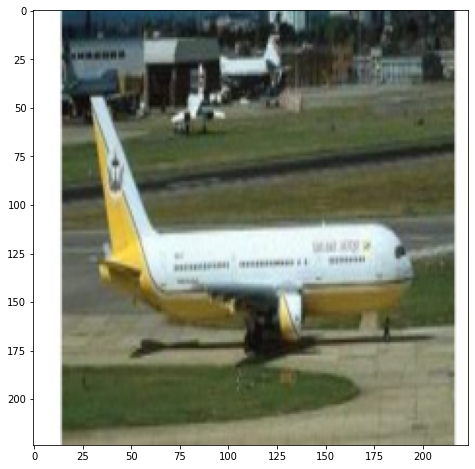

In [30]:
def unnormalize(img):
  if img.dim()==2 or ((img.dim()==3) and (img.size()[0]==1)):
      return img*std[0]+mean[0]
  return img * img.new(std).view(3, 1, 1) + img.new(mean).view(3, 1, 1)

mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
batchsize=32
image_size = 224

#Transformations à appliquer sur le dataset (transformation des images en tenseurs)
transform = transforms.Compose(
    [transforms.Resize((image_size, image_size)),
     transforms.ToTensor()])

dataset_raw = datasets.ImageFolder('drive/MyDrive/data/101_ObjectCategories', transform=transform)
loader = torch.utils.data.DataLoader(dataset_raw, batch_size=batchsize, pin_memory=True, shuffle=True)

# Recuperation du premier batch
images,labs=iter(loader).next()

print("Dimension d'un mini-batch de loader: ", images.size())
img = images[0]
print(" img.size() = ", img.size())
print(" img.dim() = ", img.dim())
print(" img.size()[0] = ", img.size()[0])

#Visualisation des images
fig=plt.figure(figsize=(8, 8))
tr = transforms.ToPILImage()
img0 = tr(img)
plt.imshow(np.array(img0))

Maintenant, je veux créer les ensembles d'apprentissage (train) et de validation (test), avec une proportion 90%:10%. Nous avons 8683 images en total.

 length raw dataset =  8683
 indices:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 

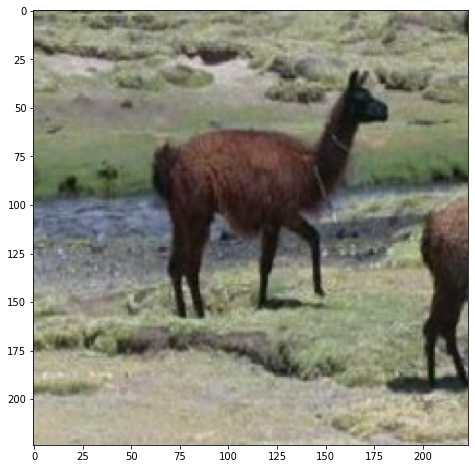

In [38]:
from torch.utils.data import Subset
from torch.utils.data.sampler import SubsetRandomSampler

proportion = 0.1

num_raw = len(dataset_raw)
indices = list(range(num_raw))
split = int(np.floor(proportion * num_raw)) # 10% pour l'ensemble de validation

print(" length raw dataset = ", num_raw)
print(" indices: ", indices)
print(" split = ", split)

# On melange les indices des images
#np.random.seed(13)
np.random.shuffle(indices)
print(" indices: ", indices)

# division en 2 ensembles, l'indice = split est la frontiere entre train et test
train_indices =  indices[split:]
print(" Train length = ", len(train_indices))
test_indices = indices[:split]
print(" Test length = ", len(test_indices))

train_dataset = Subset(dataset_raw, train_indices)
test_dataset = Subset(dataset_raw, test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, pin_memory=True, shuffle=True)

train_size = len(train_dataset)
test_size = len(test_dataset)
print(" Train & test sizes are: ", train_size, test_size)

# Recuperation du premier batch
bx, by = iter(train_loader).next()
print("Dimension d'un mini-batch de train_loader: ", bx.size())
img_bx = bx[0]
print(" img_bx.size() = ", img_bx.size())
print(" img_bx.dim() = ", img_bx.dim())
print(" img_bx.size()[0] = ", img_bx.size()[0])

#Visualisation des images
fig=plt.figure(figsize=(8, 8))
img1 = tr(img_bx)
plt.imshow(np.array(img1))